# Import requirements

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.8 MB/s 
     |████████████████████████████████| 182 kB 80.4 MB/s 
     |████████████████████████████████| 7.6 MB 92.7 MB/s 


In [ ]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (

    AutoModelForSequenceClassification,
    AutoTokenizer,

)

# 1. Preprocess

In [ ]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [ ]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [ ]:
train_pos[:10]

['2 5977 950 13 9 3',
 '2 18656 7705 365 13 9 3',
 '2 59 67 57 1954 621 18 17 1392 5262 56 25 510 254 13 9 3',
 '2 32 13 22 18 21 254 13865 69 20538 7298 13 9 3',
 '2 14 1138 25 4753 13 9 3',
 '2 254 748 950 13 9 3',
 '2 254 365 13 9 3',
 '2 11554 16 208 25 27269 17 7503 16 621 18 13 9 3',
 '2 374 209 26 4311 54 748 16385 18 17 3911 13 9 3',
 '2 14 78 978 1879 5289 13 9 3']

In [ ]:
train_neg[:10]

['2 31 23 16382 15088 13 9 3',
 '2 86 27 20 14 20538 19008 13 15 14 1186 25 297 485 16 14 2238 13 9 3',
 '2 8663 4428 17 21 13 444 16 29081 408 2473 1105 13 9 3',
 '2 626 510 621 279 52 14358 16 14 5579 13 1 6336 1 2162 3383 13 9 3',
 '2 153 13 15 14 19360 20538 7298 13 15 32 25 35 661 9957 13 9 3',
 '2 31 41 20 1372 5579 13 1 6336 1 20 3547 7372 20 14 20538 7298 13 9 3',
 '2 39 470 55 80 23 21 1906 26 14 11669 27 14 270 13 9 3',
 '2 50 42 13838 55 13 60 3',
 '2 31 23 52 228 20 1372 26 14 11669 27 14 270 13 9 3',
 '2 31 1905 32 366 408 2473 1105 13 15 20 8844 13 15 27 5757 13 15 54 11669 13 9 3']

In [ ]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [ ]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([   2, 5977,  950,   13,    9,    3]), array([1]))
(array([    2, 18656,  7705,   365,    13,     9,     3]), array([1]))
(array([   2,   59,   67,   57, 1954,  621,   18,   17, 1392, 5262,   56,
         25,  510,  254,   13,    9,    3]), array([1]))
(array([    2,    32,    13,    22,    18,    21,   254, 13865,    69,
       20538,  7298,    13,     9,     3]), array([1]))
(array([   2,   14, 1138,   25, 4753,   13,    9,    3]), array([1]))
(array([  2, 254, 748, 950,  13,   9,   3]), array([1]))
(array([  2, 254, 365,  13,   9,   3]), array([1]))
(array([    2, 11554,    16,   208,    25, 27269,    17,  7503,    16,
         621,    18,    13,     9,     3]), array([1]))
(array([    2,   374,   209,    26,  4311,    54,   748, 16385,    18,
          17,  3911,    13,     9,     3]), array([1]))
(array([   2,   14,   78,  978, 1879, 5289,   13,    9,    3]), array([1]))
(array([  2,  48, 209,  23, 253, 254,  13,   9,   3]), array([1]))


In [ ]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [ ]:
train_batch_size=128 #batch size -> 32 to 128
eval_batch_size=128 #batch size -> 64 to 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, #shuffle false -> true
                                         num_workers=2)

In [ ]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2')
model.to(device)

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [ ]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [ ]:
train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###

            if iteration != 0 and iteration % int(len(train_loader) / 20) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###

                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss

Epoch 0:   5%|▌         | 174/3463 [01:38<2:15:02,  2.46s/batch, loss=0.146]

Acc for model which have lower valid loss:  0.95475


Epoch 0:  10%|█         | 347/3463 [03:21<2:13:28,  2.57s/batch, loss=0.152]

Acc for model which have lower valid loss:  0.9645


Epoch 0:  15%|█▌        | 520/3463 [05:04<2:04:42,  2.54s/batch, loss=0.121]

Acc for model which have lower valid loss:  0.96275


Epoch 0:  20%|██        | 693/3463 [06:48<1:59:42,  2.59s/batch, loss=0.168]

Acc for model which have lower valid loss:  0.96325


Epoch 0:  25%|██▌       | 866/3463 [08:32<1:51:17,  2.57s/batch, loss=0.0701]

Acc for model which have lower valid loss:  0.9705


Epoch 0:  30%|███       | 1039/3463 [10:16<1:43:58,  2.57s/batch, loss=0.0599]

Acc for model which have lower valid loss:  0.97025


Epoch 0:  35%|███▍      | 1212/3463 [11:59<1:36:08,  2.56s/batch, loss=0.0907]

Acc for model which have lower valid loss:  0.971


Epoch 0:  50%|████▉     | 1731/3463 [17:10<1:13:41,  2.55s/batch, loss=0.027]

Acc for model which have lower valid loss:  0.9735


Epoch 0:  60%|█████▉    | 2077/3463 [20:36<59:13,  2.56s/batch, loss=0.00835]

Acc for model which have lower valid loss:  0.972


Epoch 0:  75%|███████▍  | 2596/3463 [25:45<36:58,  2.56s/batch, loss=0.0968]

Acc for model which have lower valid loss:  0.9755


Epoch 0:  80%|███████▉  | 2769/3463 [27:28<29:44,  2.57s/batch, loss=0.0645]

Acc for model which have lower valid loss:  0.974


Epoch 1:  15%|█▌        | 520/3463 [05:11<2:04:47,  2.54s/batch, loss=0.0337]

Acc for model which have lower valid loss:  0.97325


Epoch 1:  65%|██████▍   | 2250/3463 [22:27<52:14,  2.58s/batch, loss=0.0785]

Acc for model which have lower valid loss:  0.9795


Epoch 1:  95%|█████████▍| 3288/3463 [32:44<07:34,  2.60s/batch, loss=0.0646]

Acc for model which have lower valid loss:  0.977


Epoch 2:   5%|▌         | 174/3463 [01:42<2:18:37,  2.53s/batch, loss=0.0255]

Acc for model which have lower valid loss:  0.97775


Epoch 2: 100%|██████████| 3463/3463 [34:24<00:00,  1.68batch/s, loss=0.0138]


In [ ]:
endtime = time.time()

In [ ]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [ ]:
test_dataset = test_df['Id']

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

['2 32 13 22 18 21 979 78 1496 17 78 11974 18 206 85 42 162 13 9 3',
 '2 86 17841 37 40 315 3839 13 9 3',
 '2 32 25 14 127 14351 7804 19 14 1152 13 9 3',
 '2 107 52 1676 21 9140 29 158 148 13 9 3',
 '2 31 23 4741 17 39 117 55 583 86 5733 17 5575 13 9 3',
 '2 14 104 584 95 420 30 23 1047 23 14 2364 13 9 3',
 '2 90 13 15 52 14 53 18 35 28 291 13 15 14 53 18 19 1630 183 13 9 3',
 '2 59 1499 32 70 431 26 42 17 50 253 15600 13 9 3',
 '2 3123 14 13533 144 13 103 22 38 166 143 184 20 170 14 1428 13 9 3',
 '2 59 57 40 5977 3155 16 22621 18 20 3538 37 13 9 3']

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    ex0 = []
    ex1 = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        ex0 += [example[0].cpu().numpy() for example in logits]
        ex1 += [example[1].cpu().numpy() for example in logits]
        predictions += batch_predictions


Test:   9%|▉         | 3/32 [00:00<00:02, 10.99it/s]

tensor([[-3.8312,  3.8877],
        [ 3.4471, -3.6111],
        [-3.8294,  3.8882],
        [ 3.4492, -3.6128],
        [-2.6203,  2.2881],
        [ 3.1899, -3.2961],
        [ 2.8638, -2.8876],
        [-3.4165,  3.0578],
        [ 3.4490, -3.6150],
        [-3.8336,  3.8877],
        [-3.8281,  3.8887],
        [ 3.4491, -3.6011],
        [ 3.0306, -3.0216],
        [-3.8303,  3.8883],
        [-3.8316,  3.8899],
        [ 3.4493, -3.6037],
        [-0.7555,  0.2679],
        [-3.8279,  3.8876],
        [ 3.0188, -2.9971],
        [ 3.4321, -3.6084],
        [ 3.2871, -3.4425],
        [-3.8183,  3.8856],
        [ 2.3246, -2.4578],
        [-3.8327,  3.8888],
        [ 3.4333, -3.6093],
        [ 3.2486, -3.3837],
        [-3.6843,  3.5766],
        [-3.8198,  3.8834],
        [ 2.5846, -2.7057],
        [ 3.4508, -3.6097],
        [ 3.2766, -3.4325],
        [ 3.4445, -3.6117]], device='cuda:0')
tensor([[ 3.4021, -3.5905],
        [ 3.4507, -3.6133],
        [ 3.4165, -3.6008],
  


Test:  22%|██▏       | 7/32 [00:00<00:01, 16.05it/s]

tensor([[ 2.6618, -2.7568],
        [ 2.9845, -2.9658],
        [ 3.4396, -3.6109],
        [-3.8298,  3.8901],
        [-3.8338,  3.8887],
        [-3.8248,  3.8882],
        [ 3.0120, -2.9888],
        [ 3.4509, -3.6094],
        [ 3.4055, -3.5918],
        [-3.8050,  3.8704],
        [ 3.4444, -3.6122],
        [ 2.6379, -2.7411],
        [-3.8235,  3.8863],
        [ 3.4504, -3.6082],
        [-2.1345,  1.4107],
        [-3.8015,  3.8676],
        [ 2.8933, -2.9057],
        [ 2.9923, -2.9710],
        [ 2.2247, -2.3333],
        [ 3.0766, -3.1112],
        [ 3.4282, -3.6056],
        [-0.6430,  0.1706],
        [-2.2311,  1.7203],
        [ 3.1260, -3.1889],
        [ 3.4520, -3.6038],
        [ 3.4509, -3.6121],
        [-3.8220,  3.8859],
        [ 3.3841, -3.5739],
        [-1.0394,  0.5193],
        [-3.8276,  3.8889],
        [ 3.4508, -3.6103],
        [-3.5647,  3.2095]], device='cuda:0')
tensor([[-3.8342,  3.8900],
        [ 3.4528, -3.6108],
        [-3.8291,  3.8884],
  


Test:  38%|███▊      | 12/32 [00:00<00:01, 18.45it/s]

tensor([[ 3.4523, -3.6082],
        [ 3.4453, -3.5933],
        [ 3.4502, -3.6024],
        [-3.8318,  3.8890],
        [ 3.0375, -3.0371],
        [ 3.4451, -3.6114],
        [ 3.0147, -2.9897],
        [ 3.4497, -3.6029],
        [-3.8257,  3.8872],
        [ 3.4522, -3.6146],
        [ 2.4733, -2.6190],
        [-3.8131,  3.8795],
        [ 2.1044, -2.1868],
        [-3.7662,  3.8093],
        [-3.0209,  2.6998],
        [-3.8305,  3.8886],
        [-3.8072,  3.8756],
        [-3.7275,  3.7458],
        [ 3.3859, -3.5767],
        [-2.6360,  2.3438],
        [ 2.0438, -2.1104],
        [-2.6219,  2.2993],
        [ 3.4500, -3.6128],
        [ 2.5238, -2.6612],
        [ 0.4569, -0.5809],
        [ 3.4284, -3.6045],
        [ 3.0394, -3.0420],
        [-2.8676,  2.5843],
        [-3.8332,  3.8893],
        [-3.8294,  3.8881],
        [-3.8313,  3.8902],
        [-3.8272,  3.8878]], device='cuda:0')
tensor([[-3.8277,  3.8873],
        [ 2.9966, -2.9739],
        [-3.8193,  3.8853],
  


Test:  53%|█████▎    | 17/32 [00:00<00:00, 19.67it/s]

tensor([[ 3.3529, -3.5418],
        [-2.6635,  2.4008],
        [ 2.7260, -2.7980],
        [ 3.4506, -3.6022],
        [-3.8250,  3.8876],
        [-3.8289,  3.8875],
        [-3.8259,  3.8874],
        [ 3.4464, -3.5965],
        [-3.8069,  3.8783],
        [-3.8319,  3.8898],
        [ 3.4292, -3.6072],
        [ 3.4497, -3.6140],
        [-0.8770,  0.3500],
        [-3.8228,  3.8864],
        [-3.8107,  3.8769],
        [-3.8263,  3.8880],
        [ 3.4161, -3.5986],
        [ 3.4484, -3.6098],
        [ 3.3577, -3.5419],
        [-1.5869,  0.8568],
        [-3.8305,  3.8860],
        [-3.8306,  3.8902],
        [-3.6465,  3.3208],
        [-2.6918,  2.3922],
        [-3.8275,  3.8886],
        [-0.6548,  0.1896],
        [-3.8333,  3.8890],
        [ 3.1959, -3.3036],
        [-3.5241,  3.1654],
        [-3.8333,  3.8906],
        [-3.2032,  2.8522],
        [ 3.1298, -3.2007]], device='cuda:0')
tensor([[ 2.5634, -2.6905],
        [-3.8328,  3.8909],
        [-3.8299,  3.8888],
  


Test:  62%|██████▎   | 20/32 [00:01<00:00, 20.43it/s]

tensor([[-2.5004,  2.0918],
        [-3.8291,  3.8880],
        [-3.8244,  3.8869],
        [-3.8325,  3.8899],
        [-3.8239,  3.8872],
        [-3.8080,  3.8721],
        [-3.7772,  3.8407],
        [-3.6935,  3.5490],
        [-3.6701,  3.6094],
        [ 3.4403, -3.5852],
        [-0.6235,  0.1601],
        [-3.8251,  3.8872],
        [-3.7787,  3.8290],
        [ 3.4455, -3.5940],
        [-3.8295,  3.8903],
        [ 3.0066, -2.9805],
        [ 3.4540, -3.6145],
        [-3.8225,  3.8856],
        [-3.8283,  3.8877],
        [-3.8177,  3.8818],
        [-3.8270,  3.8882],
        [ 3.4487, -3.6078],
        [-3.8253,  3.8862],
        [-3.8245,  3.8863],
        [-3.8297,  3.8908],
        [ 2.9027, -2.9112],
        [ 3.0075, -2.9814],
        [ 3.0085, -2.9832],
        [ 3.4287, -3.6059],
        [-3.8250,  3.8866],
        [-3.8350,  3.8889],
        [-3.8307,  3.8899]], device='cuda:0')
tensor([[ 3.4442, -3.5920],
        [-3.7978,  3.8621],
        [ 3.4499, -3.6012],
  


Test:  81%|████████▏ | 26/32 [00:01<00:00, 20.96it/s]

tensor([[ 3.4516, -3.6080],
        [ 3.4371, -3.6085],
        [ 3.0293, -3.0169],
        [ 3.4309, -3.6069],
        [-0.7777,  0.2928],
        [-3.8296,  3.8875],
        [ 3.3879, -3.5752],
        [-1.0430,  0.5112],
        [ 3.4476, -3.5977],
        [-3.8349,  3.8902],
        [-3.8337,  3.8911],
        [-3.7848,  3.8463],
        [-3.8186,  3.8843],
        [ 3.3878, -3.5764],
        [-3.8289,  3.8898],
        [ 3.4064, -3.5933],
        [-0.9086,  0.3829],
        [ 3.0287, -3.0201],
        [ 2.8799, -2.8979],
        [-3.8246,  3.8876],
        [-3.8041,  3.8719],
        [-3.6876,  3.5580],
        [-3.8310,  3.8903],
        [ 3.1370, -3.2047],
        [ 2.9743, -2.9584],
        [-3.7850,  3.8425],
        [-3.2355,  2.8752],
        [-3.8285,  3.8873],
        [-3.8255,  3.8896],
        [ 3.3938, -3.5801],
        [-3.8088,  3.8756],
        [-3.8299,  3.8883]], device='cuda:0')
tensor([[-3.8279,  3.8878],
        [-3.7000,  3.3949],
        [-0.5961,  0.1294],
  


Test: 100%|██████████| 32/32 [00:01<00:00, 21.93it/s]

tensor([[ 3.2529, -3.3913],
        [-3.8227,  3.8862],
        [-3.8282,  3.8884],
        [-3.8353,  3.8906],
        [-3.8281,  3.8880],
        [-3.8338,  3.8899],
        [-3.8286,  3.8875],
        [ 3.4506, -3.6041],
        [-3.8289,  3.8896],
        [ 3.3519, -3.5388],
        [-3.8250,  3.8880],
        [-0.5492,  0.1238],
        [-3.8325,  3.8883],
        [-2.3344,  1.8241],
        [ 3.4505, -3.6118],
        [ 2.0966, -2.1784],
        [-3.8318,  3.8906],
        [ 3.4460, -3.6135],
        [-3.7851,  3.8462],
        [ 3.4513, -3.6082],
        [ 3.4518, -3.6089],
        [-3.7710,  3.8159],
        [ 1.6850, -1.5429],
        [ 3.4518, -3.6107],
        [-2.5080,  2.0875],
        [-3.8315,  3.8900],
        [ 2.7680, -2.8254],
        [ 3.3791, -3.5633],
        [ 3.2777, -3.4318],
        [ 3.4516, -3.6134],
        [-3.8289,  3.8878],
        [-3.7338,  3.7510]], device='cuda:0')
tensor([[-3.7185,  3.7327],
        [ 2.8389, -2.8705],
        [-1.8876,  1.1347],
  

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission_albert_base_v2.csv', index=False)

In [ ]:
test_df['ex0'] = ex0
test_df['ex1'] = ex1
test_df.to_csv('roberta_base_uncased_softvoting.csv', index=False)

In [ ]:
print(lowest_valid_loss)

0.06067490216810256


In [ ]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460]
[0.95475, 0.9645, 0.96275, 0.96325, 0.9705, 0.97025, 0.971, 0.97275, 0.97275, 0.9735, 0.9705, 0.972, 0.972, 0.96575, 0.9755, 0.974, 0.97475, 0.97375, 0.9715, 0.973, 0.9735, 0.974, 0.97325, 0.97625, 0.973, 0.97575, 0.977, 0.976, 0.974, 0.975, 0.9765, 0.97875, 0.9795, 0.97675, 0.97775, 0.9735, 0.97675, 0.97475, 0.977, 0.97725, 0.97775, 0.973, 0.9775, 0.97375, 0.97475, 0.97625, 0.97525, 0.97475, 0.97625, 0.97275, 0.97525, 0.97475, 0.97525, 0.977, 0.97625, 0.97625, 0.9765, 0.97425, 0.97725, 0.97675]
[0.14747694483958185, 0.12262147874571383, 0.11120445153210312, 0.1066860246937722, 0.08434447424951941, 0.0816002361534629, 0.07832096342463046, 0.07959

In [ ]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1903, 2076, 2249, 2422, 2595, 2768, 2941, 3114, 3287, 3460, 3635, 3808, 3981, 4154, 4327, 4500, 4673, 4846, 5019, 5192, 5365, 5538, 5711, 5884, 6057, 6230, 6403, 6576, 6749, 6922, 7097, 7270, 7443, 7616, 7789, 7962, 8135, 8308, 8481, 8654, 8827, 9000, 9173, 9346, 9519, 9692, 9865, 10038, 10211, 10384]


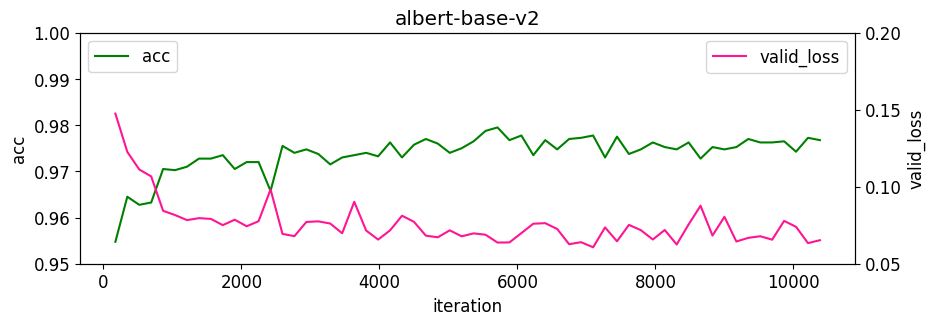

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper left')
ax1.set_ylim([0.950,1])

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0.05,0.2])

plt.title("albert-base-v2")

plt.show()

In [ ]:
print(endtime - starttime)

6197.057875394821
